# DSM 150 NEURAL NETWORK COURSEWORK

# Introduction

`Intro`

The usage of the neural networks, and deep neural networks in particular, is extremely high nowdays. Is is actually hard to say where they are not used:
- healthcare:
    - image data recognition for diagnosys (tumors, pneumonia) 
- security:
    - passport control at airports
    - road signs management
    - street surveillance 
- bussiness:
    - production control
    - autonomous vehicles
    - on-line stores and streaming/video services
- entertainment
    - social networks
    - deepfake applications

and many more.

Of course, for each particular task there is a suitable category of the network. In this coursework will be used Artificial Neural Network (ANN) with several dense layers - Deep Neural Network (DNN) - for the problem of products image recognition. The chosen dataset was kindly assembled by the e-commerce fashion German giant Zalando and provided through the library interface by TensorFlow. The name of the dataset is FashionMNIST, it contains 70000 fashion products of 10 categories in the form of image.  In more details dataset will be discussed below.

`Objectives`

With this courseworks I aim to learn how to:
1. preform various operations on high rank tensors
2. udestand dependecies and influence of hyperparametrs and features on model performance
3. build deep neural network models with dense layers with the use of interface provided by Keras from TesnsorFlow
4. reach performance of meaningful confidence (higher than 85%)
5. interpret results and find weak sides that can be improved
6. write suggestions on model's preformance improvement

`Baseline performance`

Speaking of the baseline accuracy, I would like to be realistic and set it up on 85% for the whole dataset and 70% the lowest for each category. I do understand that this is unacceptable low confidence for real-life applications and they are likely to aim to reach accuracy higher than 95% and 85% respectively. But in the same time:
1. This course work is restricted to use exactely Dense Layers, whlist Convolutional Neural Networks (CNN) is more reasonable choice for the image recognition problem. 
2. Dataset might be quite variegated and model for some of the classes might outperfrom, whlist for some predict fairly poor. 

`Evauation techniques`

Adding to the mentioned above, in my opinion evaluation of the model is alson reasonable to perform separately for each class. I will calculate the follwoing metrics:
- accuracy per model and per class
- precision and recall per calss

As visulization, I will use confusion matrix and plot images along with predicted label, probability value of the prediction and true value. Confusion matrix is a great technique to show weak sides and bottlenecks of the model, and also can serve as a visual confirmation of precision/recall metrics calculation.

`Preparation steps`

1. Import libraries:

In [1]:
#ML library and data load

#%pip install tensorflow
#%pip install tensorflow_addons
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow_addons import metrics


#supportive libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

2. Load and presentation of the dataset:

Loading dataset from the TensorFlow (TF) library, which also provides the possibility of splitting dataset into train and test sets simultaneously.

In [2]:
#load data
(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data() 

`Dataset presentation`

As mentioned before, for this coursework image dataset of products was chosen, namely - clothes items of 10 categories. For the the purpose of visual and further use, here is the dictionary with mapped class on product name:

In [3]:
#mapping dictionary
clothes = {0:"T-shirt/top", 
           1:"Trousers",
           2:"Pullover",
           3:"Dress",
           4:"Coat",
           5:"Sandal",
           6:"Shirt",
           7:"Sneaker",
           8:"Bag",
           9:"Ankle boot"}

for i in clothes:
    print("Class", i, ' - ', clothes[i])

Class 0  -  T-shirt/top
Class 1  -  Trousers
Class 2  -  Pullover
Class 3  -  Dress
Class 4  -  Coat
Class 5  -  Sandal
Class 6  -  Shirt
Class 7  -  Sneaker
Class 8  -  Bag
Class 9  -  Ankle boot


source of the labels for mapping dictionary: https://www.tensorflow.org/datasets/catalog/fashion_mnist

The dataset consists of 70000 images (X) of 28x28 pixel size and 70000 labeles (Y) in the form of figure [0-9] that belongs to one of 10 classes:

In [4]:
#shapes
print("Train data is a tensor of shape:", x_train.shape, ", and rank of", tf.shape(x_train).shape[0])
print("Train lables is a tensor of shape:", y_train.shape, ", and rank of", tf.shape(y_train).shape[0])
print("\n")
print("Test data shape:", x_test.shape, ", and rank of", tf.shape(x_test).shape[0])
print("Test lables is a tensor of shape:", y_test.shape, ", and rank of", tf.shape(y_test).shape[0])

Train data is a tensor of shape: (60000, 28, 28) , and rank of 3
Train lables is a tensor of shape: (60000,) , and rank of 1


Test data shape: (10000, 28, 28) , and rank of 3
Test lables is a tensor of shape: (10000,) , and rank of 1


In [5]:
# supporting custom function that plots 3x3 subplots
def plot_fashion(x, y, bias):
    
    fig, axs = plt.subplots(3,3,figsize=(7, 7))
    assert x.ndim == 3, "x has to be rank 3 tensor"
    
    for i in range(3):
        for j in range(3):
            axs[i,j].imshow(x[i+j+bias], cmap = plt.cm.binary)
            axs[i,j].set_title(str(y[i+j+bias]) + ": " + str(clothes[y[i+j+bias]]))
            axs[i,j].axis('off')
            
    fig.tight_layout()
    plt.show()

Here are several examples of how the dataset images look like:

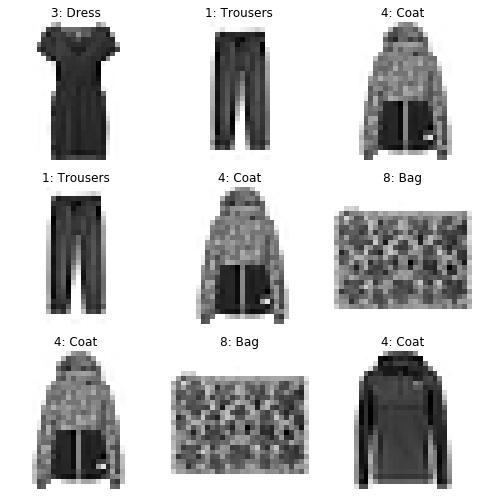

In [6]:
#training data
plot_fashion(x_train, y_train, 20)

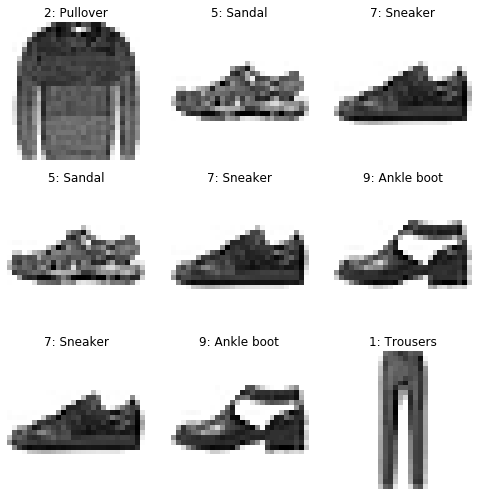

In [7]:
#test data
plot_fashion(x_test, y_test, 20)

Both visulazations present very modest quality. The first prominent thing one can see is the similarity between pullover and coat. Even for me, human being, it would be such a task to distinguish between those. Coat in the down right corner of the training set visualization looks like a sweartshirt (Pullover) to me. I assume that poor quality of images and obvious similarity of data samples belonging to dofferent classes might be quite challanging for the model, whil will definitely have impact on the performance.

The last important step before jumping into data pre-processing is to verify if the dataset is balanced - meaning that it contains approximately equal quantity of dat samples of each category.

In [8]:
unique, counts = np.unique(y_train, return_counts = True)
counts

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000],
      dtype=int64)

Result: Dataset is 100% balanced - each class has the same quantity of samples.

# Methodology

Overall the process includes the follwoing 3 steps:
1. Data preparation
2. Building and Training Neural Network model
3. Test model on unseen data

Detailed methodology is described below.

#### 1. Data preparation a.k.a.  Data pre-processing

`Step 1` Go from rank 3 tensor to rank 2.

Before flattering:
- dim 1: intensity
- dim 2: coordinate for axis X (0-28)
- dim 3: coordinate for axis Y (0-28)

After flattering:
- dim 1: intensity
- dim 2: coordinate for axis X (0-784)


In [9]:
#save x_test in original format for conclusions
x_test_orig = x_test

#flattened pixel map
x_train = x_train.reshape((60000, 28 * 28))
x_test = x_test.reshape((10000, 28 * 28))


In [10]:
print("After flattering:")
print("\nTrain data shape: ", x_train.shape)
print("Test data shape: ", x_test.shape)


After flattering:

Train data shape:  (60000, 784)
Test data shape:  (10000, 784)


`Step 2` Data normalization.

It refers to scaling values to the value between 0 and 1. This step will balance data set and hence boost performance.

In [11]:
#convert integer to float and scale (make value between 0 and 1)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

`Step 3` Hot encoding

One of the network engineering strategy (discussed later on) requires encoding lables in accordance with one-hot encoding logic.

Example of one-hot encoding:
- 5 -> [0,0,0,0,0,1,0,0,0,0]
- 2 -> [0,0,1,0,0,0,0,0,0,0]

In [12]:
#one-hot encoding
def one_hot_encoding(y):
    encoded = np.zeros((len(y),10))
    for i in range(len(y)):
        assert y[i]<10, "Check vector values, they should be between 0 and 9"
        encoded[i,y[i]] = 1 
    
    return encoded   
        

In [13]:
#encode labels
y_train_hot = one_hot_encoding(y_train)
y_test_hot = one_hot_encoding(y_test)

In [14]:
print("One-hot encoded labels' shape:")
print("\nTrain lables: ", y_train_hot.shape)
print("Test lables: ", y_test_hot.shape)

One-hot encoded labels' shape:

Train lables:  (60000, 10)
Test lables:  (10000, 10)


`Step 4` Validation set

Here I put aside part of the training set as a validation set (separatly for hot-encoded labels and integer labels) in order to use its performance for hyperparametrs tunning:

In [15]:
x_train_val = x_train[:len(x_test),:]
x_train_part = x_train[len(x_test):,:]

y_train_val = y_train[:len(x_test)]
y_train_part = y_train[len(x_test):]

y_train_hot_val = y_train_hot[:len(x_test),:]
y_train_hot_part = y_train_hot[len(x_test):,:]

print("Shapes after validation set creation:")
print("\nData validation set: ", x_train_val.shape)
print("\nData training set: ", x_train_part.shape)
print("\nLabels validation set: ", y_train_val.shape)
print("\nLabels training set: ", y_train_part.shape)
print("\nLabels validation set hot-encoded: ", y_train_hot_val.shape)
print("\nLables training set hot-encoded: ", y_train_hot_part.shape)



Shapes after validation set creation:

Data validation set:  (10000, 784)

Data training set:  (50000, 784)

Labels validation set:  (10000,)

Labels training set:  (50000,)

Labels validation set hot-encoded:  (10000, 10)

Lables training set hot-encoded:  (50000, 10)


Data is ready for training Neural Network. But firstly it has to be built. 

#### 2. Building and Training Neural Network

Im order to build and compile Neural Network the following is required:

|     |                  |   |  Stage      |     |                    |
|-----|:-----------------|---|:------------|:----|:-------------------|
|**1**|**parameters**    | \|| building   | \|  | initialized by engineer and tuned with the help of optimmizer|
|**2**|**hyperparametrs**| \|| building, compilation, trainnig   | \|  | tuned by engineer  |
|**3**|**strategy**      | \|| compilation| \|  | defined by engineer|


***For Neural Networks***


`parametrs` are:
- weihgts
- biases

`hyperparametrs` generally  may include:
- Network level:
    - quantity of hidden layers
- Layer level:
    - quantity of hidden units
    - activation function
    - regularization term
- Compilation stage*:
    - learning rate
    - momentum
    
Some aources also reffers to the following as hyperparameters:
- Training stage:   
    - minibatch size 
    - epochs

\* *list depends on the chosen optimizer*


`strategy` reffers to the choice of:
- loss function
- optimization function

***

**source**: Towards Data Science - https://towardsdatascience.com/neural-networks-parameters-hyperparameters-and-optimization-strategies-3f0842fac0a5

Since the parametrs are initilized in the moment of calling function and tuned by the optimizer, here will be only 2 steps:

1. Defining strategy
2. Defining a set of hyperparametrs to start

##### Implementation:

**`Step 1` Defining strategy**

Strategy fully depends on the type of problem we need to solve. As it mention before, here we face a single-lable multiclass problem. 

Hence, the best candidate for `loss-function` would  be:

| |                                |Note               |
|-|:-------------------------------|-------------------|
|1|Multi-class cross-entropy       | hot-encoded lables|
|2|Sparse categorical cross-entropy| integer labels    |

Even though both candidates are said to perform similarly good, the source emphasizes that for the problem where each data sample belongs only to 1 class, `sparse categorical cross-entropy` would be a better choice - it helps to save time and memory. The reason for this lays in the way these losses are calculated. `categorical cross-entropy` anticipates one-hot encoded labels and hence more diamensions are involed into mathematical operations, whlist `sparse categorical cross-entropy` requires integer label and. This problem has only 10 classes, so difference might be small. Both of them will be tested on 1 example just in sake of timing comparing.

**The source**: Stack Exchange (Data Science) - https://datascience.stackexchange.com/questions/41921/sparse-categorical-crossentropy-vs-categorical-crossentropy-keras-accuracy

There are 8 `optimizers` available in Keras in total. For this problem I will use one of the most popular of them:


| |                                |
|-|:-------------------------------|
|1|RMSprop                         |



Before moving forward, let me introduce a function to automate the building process:

In [16]:

def experiment (activation, hidden_units, hidden_layers, loss, learning_rate = 0, momentum = 0, 
                optimizer = 'RMSprop', l2 = 0):

    model = models.Sequential()
    
    if l2 == 0:
        model.add(layers.Dense(hidden_units, activation = activation[0], 
                               input_shape = (28*28,),
                              kernel_regularizer=regularizers.l2(l2))) #visible input
        
        for i in range(1, hidden_layers+1):
            model.add(layers.Dense(hidden_units, activation = activation[0])) #hidden layers
    
    else:
        model.add(layers.Dense(hidden_units, activation = activation[0], input_shape = (28*28,))) #visible input
        
        for i in range(1, hidden_layers+1):
            model.add(layers.Dense(hidden_units, activation = activation[0], 
                                   kernel_regularizer=regularizers.l2(l2))) #hidden layers
    
    model.add(layers.Dense(10, activation = activation[1]))#visible output
    
    if optimizer == 'RMSprop':
        if learning_rate == 0 and momentum == 0:
            from tensorflow.keras import optimizers
            model.compile(optimizer = optimizers.RMSprop(),
                     loss=loss,
                     metrics=['accuracy', metrics.MultiLabelConfusionMatrix(num_classes = 10)])
        if learning_rate != 0 and momentum == 0:
            from tensorflow.keras import optimizers
            model.compile(optimizer = optimizers.RMSprop(learning_rate = learning_rate),
                     loss=loss,
                     metrics=['accuracy', metrics.MultiLabelConfusionMatrix(num_classes = 10)])
        if learning_rate == 0 and momentum != 0:
            from tensorflow.keras import optimizers
            model.compile(optimizer = optimizers.RMSprop(momentum = momentum),
                     loss=loss,
                     metrics=['accuracy', metrics.MultiLabelConfusionMatrix(num_classes = 10)])
        if learning_rate != 0 and momentum != 0:
            from tensorflow.keras import optimizers
            model.compile(optimizer = optimizers.RMSprop(learning_rate = learning_rate, momentum = momentum),
                     loss=loss,
                     metrics=['accuracy', metrics.MultiLabelConfusionMatrix(num_classes = 10)])
    
    return model

And right away use it to build a model with a random set of parametrs and feature values.

In [17]:
history0 = []
activation = ['sigmoid', 'tanh']
hidden_units = 50
hidden_layers = 1
loss = 'categorical_crossentropy'
epochs = 5

model0 = experiment(activation, hidden_units, hidden_layers, loss)
history0.append(model0.fit(x_train_part, y_train_hot_part, 
                epochs = 5, validation_data = (x_train_val, y_train_hot_val)))

Epoch 1/5
1563/1563 [==============================] - 5s 2ms/step - loss: 10.8292 - accuracy: 0.1733 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 11.0280 - val_accuracy: 0.1766 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 2/5
1563/1563 [==============================] - 3s 2ms/step - loss: 10.8478 - accuracy: 0.1734 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 11.0280 - val_accuracy: 0.1766 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 3/5
1563/1563 [==============================] - 3s 2ms/step - loss: 10.8478 - accuracy: 0.1734 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 11.0280 - val_accuracy: 0.1766 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 4/5
1563/1563 [==============================] - 4s 2ms/step - loss: 10.8478 - accuracy: 0.1734 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 11.0280 - val_accuracy: 0.1766 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 5/5
1563/1563 [==============================] - 3s 2ms/step - los

In [18]:
print("The set of hyperparametrs:\n")
print('Activation:\t', activation)
print('Hidden layers:\t', hidden_layers)
print('Hidden units:\t', hidden_units)
print('Regularization:\t none')
print('Learning rate:\t auto')
print('Momentum:\t auto')
print('Loss:\t\t', loss)
print('\nAlso:\n')
print('Epochs:\t', epochs)
print('Mini-batch:\t none')

max_val_acc_0 = np.round(np.max([i.history['val_accuracy'] for i in history0]), 2)

print('----')
print('Maximum accuracy of the validation set: ', max_val_acc_0)

The set of hyperparametrs:

Activation:	 ['sigmoid', 'tanh']
Hidden layers:	 1
Hidden units:	 50
Regularization:	 none
Learning rate:	 auto
Momentum:	 auto
Loss:		 categorical_crossentropy

Also:

Epochs:	 5
Mini-batch:	 none
----
Maximum accuracy of the validation set:  0.18


The random set of hyperparametrs and features performed fairly poor - accuracy on the validation set reaches maximum at just 18%. It is evident - hyperparametrs tunning is required.

**`Step 2` Hyperparametrs tunning and features discussion**

In order to save time and electrical power, I will apply some theoretical knoweledge to the hyperparametr choice before tunning.

`Activation function` options discussion:

>     - for hidden layer ReLU serves better than Sigmoid and Tanh in accordance with the source: "it is both simple to implement and effective at overcoming the limitations of other previously popular activation functions, such as Sigmoid and Tanh."
     - for output layer there are equal possibilities of softmax and sigmoid function for classification problem.
>**The source**: Machine Learning Mastery - https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/


For this problem the following activation functions will be used:

| |Input and hidden layer |Output layer      |
|-|:----------------------|:-----------------|
|1|Relu                   |Softmax           |


`Hidden layers` options discussion:

In order to decide on quantity of hidden layers - I used the follwing table:

![layers.png](layers.png)

Considering that dataset is balanced and fairly big, I will start with the quantity of hidden layers at `2`.

**The source**: https://www.heatonresearch.com/2017/06/01/hidden-layers.html

`Hidden neurons` options discussion:

For the decision of the hidden units diamensions, I used some ideas from the source above:

![neurons.png](neurons.png)

- Input layer: 784
- Output layer: 10

Make a use of first 2 points, I ended up with ~ `512` hidden units.


`Epochs` discussion

The quanity of epochs (times the whole datset does through the NN) has direct influence on the ability of the model to generalize. Before some point the model is underfitting, then 'plato' with optimal quantity of eopchs, and then model reaches ovefitting - training accuracy raises while validation is decreasing. There is no rule of thumb how to find the best quantity, only real model training and comapring accuracies on validation and training sets. To find the optimal quantity I will purpously choose `20` epochs to reach overfitting and then choose the value from the plato.

`Batch size` discussion

Batch size I set up as `512` based on the experience gained during studies and considering size of the dataset. It is not something to be tuned in order to influence on the performence, rather parametr having influence on the time, needed for the training. 

As a result of the discussion the following options of hyperparametrs will be used as a starting point:

In [19]:
activation = ['relu', 'softmax']
hidden_units = 512
hidden_layers = 2
loss = ['categorical_crossentropy', 'sparse_categorical_crossentropy'] #first to be compared 

In [20]:
epochs = 30
batch_size = 512

Before was mentioned that categorical and sparse categorical crossentropy might perfrom nearly the same good, however with different resources use. Here is the test to compare difference in running time and accuarcy on validation set:

In [21]:
cat_history = [] #array to store history objects for categorical cross-entropy
sparse_history = [] #array to store history objects for sparse categorical cross-entropy

In [22]:
#model build with categorical cross-entropy loss

start = time.time() #start time count

# build and train model
model1 = experiment(activation, hidden_units, hidden_layers, loss[0])
cat_history.append(model1.fit(x_train_part, y_train_hot_part, 
                epochs = epochs, batch_size = batch_size,
                validation_data = (x_train_val, y_train_hot_val)))

end = time.time() #end time count

cat_timing = end-start

Epoch 1/30
98/98 [==============================] - 5s 44ms/step - loss: 0.7892 - accuracy: 0.7145 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.8506 - val_accuracy: 0.7220 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 2/30
98/98 [==============================] - 4s 41ms/step - loss: 0.4911 - accuracy: 0.8165 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.4384 - val_accuracy: 0.8440 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 3/30
98/98 [==============================] - 4s 43ms/step - loss: 0.4144 - accuracy: 0.8454 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.3853 - val_accuracy: 0.8586 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 4/30
98/98 [==============================] - 4s 42ms/step - loss: 0.3747 - accuracy: 0.8595 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.4087 - val_accuracy: 0.8514 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 5/30
98/98 [==============================] - 4s 43ms/step - loss: 0.3446 - accura

In [23]:
# model build with sparse categorical cross-entropy loss

start = time.time() #start time count

# build and train model
model2 = experiment(activation, hidden_units, hidden_layers, loss[1])
sparse_history.append(model2.fit(x_train_part, y_train_part, 
                      epochs = epochs, batch_size = batch_size,
                      validation_data = (x_train_val, y_train_val)))

end = time.time() #end time count

sparse_timing = end-start

Epoch 1/30
98/98 [==============================] - 5s 44ms/step - loss: 0.7843 - accuracy: 0.7156 - Multilabel_confusion_matrix: 22491.3496 - val_loss: 0.5312 - val_accuracy: 0.8054 - val_Multilabel_confusion_matrix: 4507.1250
Epoch 2/30
98/98 [==============================] - 4s 42ms/step - loss: 0.4839 - accuracy: 0.8198 - Multilabel_confusion_matrix: 22486.1758 - val_loss: 0.4366 - val_accuracy: 0.8362 - val_Multilabel_confusion_matrix: 4506.6250
Epoch 3/30
98/98 [==============================] - 4s 43ms/step - loss: 0.4171 - accuracy: 0.8445 - Multilabel_confusion_matrix: 22475.0508 - val_loss: 0.4200 - val_accuracy: 0.8463 - val_Multilabel_confusion_matrix: 4502.7251
Epoch 4/30
98/98 [==============================] - 4s 43ms/step - loss: 0.3715 - accuracy: 0.8611 - Multilabel_confusion_matrix: 22460.4258 - val_loss: 0.4435 - val_accuracy: 0.8482 - val_Multilabel_confusion_matrix: 4496.2998
Epoch 5/30
98/98 [==============================] - 4s 42ms/step - loss: 0.3473 - accura

Assuming 4 parametrs x 3 options each testified - getting 81 exclusive options.
In this case, the total time needed for each algorithm is:

In [24]:
cat_total = cat_timing*81
sparse_total = sparse_timing*81

print("50 epochs, 81 exclusive options: ")
print("Time with categorical cross-entropy : ~", np.round((cat_total/3600),2), " hour(s)")
print("Time with sparse categorical cross-entropy: ~", np.round((sparse_total/3600),2), " hour(s)")



50 epochs, 81 exclusive options: 
Time with categorical cross-entropy : ~ 2.84  hour(s)
Time with sparse categorical cross-entropy: ~ 2.9  hour(s)


Performance of the two models:

In [25]:
cat_max_val_accu = np.max(cat_history[0].history['val_accuracy'])
sparse_max_val_accu = np.max(sparse_history[0].history['val_accuracy'])

cat_max_accu = np.max(cat_history[0].history['accuracy'])
sparse_max_accu = np.max(sparse_history[0].history['accuracy'])

print("Categorical cross-entropy")
print("Maximum validation accuracy: ", np.round(cat_max_val_accu, 3))
print("Maximum training accuracy: ", np.round(cat_max_accu, 3))

print("\nSparse categorical cross-entropy")
print("Maximum validation accuracy: ", np.round(sparse_max_val_accu,3))
print("Maximum training accuracy: ", np.round(sparse_max_accu, 3))

Categorical cross-entropy
Maximum validation accuracy:  0.899
Maximum training accuracy:  0.948

Sparse categorical cross-entropy
Maximum validation accuracy:  0.9
Maximum training accuracy:  0.949


Results shows that:
1. Both models requires equal time to run
2. Both models performs as the same lelev
3. Both models **overfits**

As per lecture notes, it is always a good idea to plot accuracies and/or in respect to epochs for training and validation sets. It helps not only to visualize overfitting, but also shows overall behaivor of the model and ease evaluation process. Here is the function (inspired by the class notes) helping to do so:

In [26]:
# custom plotting fuction        
def plot_results (y1, y1_label, y2, y2_label, title):    
    
    x =  range(1, len(y1)+1)

    plt.plot(x, y1, label = y1_label)
    plt.plot(x, y2, label = y2_label)
    plt.xlabel('Epochs')
    plt.title(title)
    plt.legend()
    plt.show()


Categorical crossentropy vs. Sparse categorical crossentropy Accuracy on validation set:

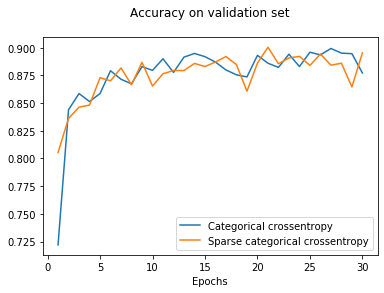

In [27]:
y1 = cat_history[0].history['val_accuracy']
y1_label = 'Categorical crossentropy'
y2 = sparse_history[0].history['val_accuracy']
y2_label = 'Sparse categorical crossentropy'
plot_results (y1, y1_label, y2, y2_label, "Accuracy on validation set\n")

Accurcies on training and validation sets for both models:

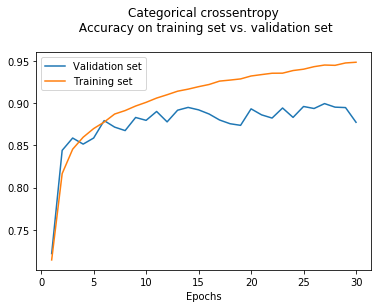

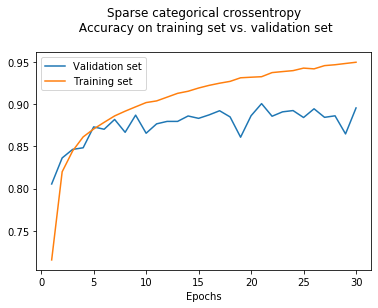

In [28]:

y1 = cat_history[0].history['val_accuracy']
y1_label = 'Validation set'
y2 = cat_history[0].history['accuracy']
y2_label = 'Training set'
plot_results (y1, y1_label, y2, y2_label, 
              "Categorical crossentropy\n Accuracy on training set vs. validation set\n")

y1 = sparse_history[0].history['val_accuracy']
y1_label = 'Validation set'
y2 = sparse_history[0].history['accuracy']
y2_label = 'Training set'
plot_results (y1, y1_label, y2, y2_label, 
              "Sparse categorical crossentropy\n Accuracy on training set vs. validation set\n")

Here we can see that indeed both loss functions perform roughly equaly - both in terms of accuracy and overfitting. The difference in working time is insufficient due to relatively small quantity of classes (10 classes). 

All things considered, I move forward with `categorical crossentropy`. However, before hyperparametrs tunning I first address overfitting by adding regularization term. In order to choose optimal value, I testify 4 regularization terms to find out which keeps the highest accuracy on the validation set:

In [29]:
l2_set = [0.01, 0.02, 0.08, 0.1]
loss = loss[0]

The following function is called to automate the process of l2 regularization terms testifying.

In [30]:
l2_history = [] #array to store history objects
l2_param_dict = {} #dictionary to store respective value of the reularization term

def l2_test(l2_set):
    count = 0
    for l2 in l2_set:
        l2_param_dict[count] = {"l2": l2}
        model = experiment(activation, hidden_units, hidden_layers, 
                           loss, l2 = l2)
        l2_history.append(model.fit(x_train_part, y_train_hot_part, epochs = epochs, 
                          batch_size = batch_size,
                          validation_data = (x_train_val, y_train_hot_val)))
        count = count+1

In [31]:
l2_test(l2_set)

Epoch 1/30
98/98 [==============================] - 5s 46ms/step - loss: 3.8775 - accuracy: 0.6848 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 1.1746 - val_accuracy: 0.8053 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 2/30
98/98 [==============================] - 4s 43ms/step - loss: 0.9078 - accuracy: 0.7895 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.7327 - val_accuracy: 0.8028 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 3/30
98/98 [==============================] - 4s 45ms/step - loss: 0.6499 - accuracy: 0.8169 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.6084 - val_accuracy: 0.8232 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 4/30
98/98 [==============================] - 4s 43ms/step - loss: 0.5654 - accuracy: 0.8340 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.5669 - val_accuracy: 0.8257 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 5/30
98/98 [==============================] - 4s 42ms/step - loss: 0.5187 - accura

Epoch 7/30
98/98 [==============================] - 4s 43ms/step - loss: 0.5054 - accuracy: 0.8508 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.4939 - val_accuracy: 0.8560 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 8/30
98/98 [==============================] - 4s 43ms/step - loss: 0.4827 - accuracy: 0.8563 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.4867 - val_accuracy: 0.8529 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 9/30
98/98 [==============================] - 4s 46ms/step - loss: 0.4624 - accuracy: 0.8623 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.4352 - val_accuracy: 0.8711 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 10/30
98/98 [==============================] - 4s 46ms/step - loss: 0.4486 - accuracy: 0.8664 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.4275 - val_accuracy: 0.8741 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 11/30
98/98 [==============================] - 4s 42ms/step - loss: 0.4347 - accu

Epoch 13/30
98/98 [==============================] - 4s 44ms/step - loss: 0.5078 - accuracy: 0.8562 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.5385 - val_accuracy: 0.8442 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 14/30
98/98 [==============================] - 4s 43ms/step - loss: 0.5005 - accuracy: 0.8573 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.4745 - val_accuracy: 0.8680 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 15/30
98/98 [==============================] - 4s 43ms/step - loss: 0.4883 - accuracy: 0.8612 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.5065 - val_accuracy: 0.8535 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 16/30
98/98 [==============================] - 4s 43ms/step - loss: 0.4792 - accuracy: 0.8637 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.4648 - val_accuracy: 0.8663 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 17/30
98/98 [==============================] - 4s 43ms/step - loss: 0.4718 - a

Epoch 19/30
98/98 [==============================] - 5s 46ms/step - loss: 0.4777 - accuracy: 0.8634 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.5298 - val_accuracy: 0.8484 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 20/30
98/98 [==============================] - 4s 45ms/step - loss: 0.4695 - accuracy: 0.8672 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.5076 - val_accuracy: 0.8543 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 21/30
98/98 [==============================] - 4s 44ms/step - loss: 0.4657 - accuracy: 0.8683 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.4964 - val_accuracy: 0.8577 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 22/30
98/98 [==============================] - 4s 44ms/step - loss: 0.4646 - accuracy: 0.8690 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.4583 - val_accuracy: 0.8713 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 23/30
98/98 [==============================] - 5s 46ms/step - loss: 0.4545 - a

Here are the findings on the regularization term values after training 4 models:

In [32]:
l2_max_accuracies = [] #array to srore max accuracies on the validation set for each l2 term option 
print("--- Various options of regularization term l2 ---\n")
print("Comparing accuracies on the validation set:\n")


for l2 in range(len(l2_history)):
    l2_max_accuracies.append(max(l2_history[l2].history['val_accuracy']))
    print(l2_param_dict[l2]," - ", max(l2_history[l2].history['val_accuracy']))

l2_max_ind = np.argmax(l2_max_accuracies) #finding the index of max accuracy in order to find the best value

print ("\n\nThe highest accuracy: ", np.max(l2_max_accuracies), 
       " is given by : \n", l2_param_dict[l2_max_ind])

--- Various options of regularization term l2 ---

Comparing accuracies on the validation set:

{'l2': 0.01}  -  0.8962000012397766
{'l2': 0.02}  -  0.8895999789237976
{'l2': 0.08}  -  0.8756999969482422
{'l2': 0.1}  -  0.8741999864578247


The highest accuracy:  0.8962000012397766  is given by : 
 {'l2': 0.01}


Validation and training sets accuraies visualization:

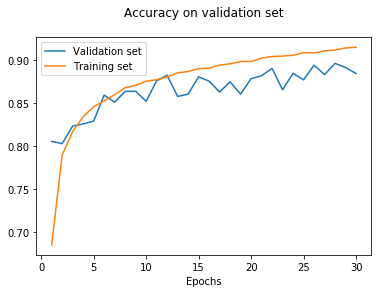

In [33]:
y1 = l2_history[l2_max_ind].history['val_accuracy']
y1_label = 'Validation set'
y2 = l2_history[l2_max_ind].history['accuracy']
y2_label = 'Training set'
plot_results (y1, y1_label, y2, y2_label, "Accuracy on validation set\n")

Indeed, adding of regularization term results into smoothing of validation set.

Reached with l2 term accuracy is quite high and satisfy defined baseline performance. But here I try to manually tune learning rate and momentum in order ro potentially improve performance:

In [34]:
learning_rate_set = [0.001, 0.005, 0.01]
momentum_set = [0.001, 0.005, 0.01]
l2 = l2_param_dict[l2_max_ind]['l2']

Again, here is the function that automates building and iterating processes:

In [35]:
lr_momentum_history = [] #array to store history objects
param_dict = {} #array to store respective values of parametrs

def lr_momentum_test(lr_set, mom_set):
    count = 0
    for lr in lr_set:
        for momentum in mom_set:
            
            param_dict[count] = {"lr": lr, "momentum" : momentum}
            model = experiment(activation, hidden_units, hidden_layers, loss,
                               learning_rate = lr, momentum = momentum, l2=l2)
            lr_momentum_history.append(model.fit(x_train_part, y_train_hot_part, epochs = epochs, 
                                  batch_size = batch_size,
                                  validation_data = (x_train_val, y_train_hot_val)))
            count = count+1


In [36]:
lr_momentum_test(learning_rate_set, momentum_set)

Epoch 1/30
98/98 [==============================] - 5s 42ms/step - loss: 3.9387 - accuracy: 0.6737 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 1.3706 - val_accuracy: 0.7326 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 2/30
98/98 [==============================] - 4s 40ms/step - loss: 0.9242 - accuracy: 0.7866 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.7199 - val_accuracy: 0.8141 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 3/30
98/98 [==============================] - 4s 40ms/step - loss: 0.6741 - accuracy: 0.8124 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.7467 - val_accuracy: 0.7549 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 4/30
98/98 [==============================] - 4s 41ms/step - loss: 0.5902 - accuracy: 0.8296 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.5641 - val_accuracy: 0.8363 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 5/30
98/98 [==============================] - 4s 40ms/step - loss: 0.5418 - accura

Epoch 7/30
98/98 [==============================] - 4s 39ms/step - loss: 0.4884 - accuracy: 0.8517 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.5146 - val_accuracy: 0.8391 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 8/30
98/98 [==============================] - 4s 41ms/step - loss: 0.4637 - accuracy: 0.8586 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.4499 - val_accuracy: 0.8647 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 9/30
98/98 [==============================] - 4s 41ms/step - loss: 0.4471 - accuracy: 0.8635 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.4837 - val_accuracy: 0.8479 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 10/30
98/98 [==============================] - 4s 41ms/step - loss: 0.4326 - accuracy: 0.8662 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.4232 - val_accuracy: 0.8737 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 11/30
98/98 [==============================] - 4s 40ms/step - loss: 0.4227 - accu

Epoch 13/30
98/98 [==============================] - 5s 47ms/step - loss: 0.4065 - accuracy: 0.8743 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.4234 - val_accuracy: 0.8697 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 14/30
98/98 [==============================] - 4s 44ms/step - loss: 0.3971 - accuracy: 0.8763 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.4177 - val_accuracy: 0.8705 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 15/30
98/98 [==============================] - 5s 50ms/step - loss: 0.3899 - accuracy: 0.8780 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.4146 - val_accuracy: 0.8637 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 16/30
98/98 [==============================] - 4s 41ms/step - loss: 0.3813 - accuracy: 0.8815 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.3949 - val_accuracy: 0.8792 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 17/30
98/98 [==============================] - 5s 52ms/step - loss: 0.3750 - a

Epoch 19/30
98/98 [==============================] - 4s 41ms/step - loss: 0.3687 - accuracy: 0.8819 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.3959 - val_accuracy: 0.8706 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 20/30
98/98 [==============================] - 4s 40ms/step - loss: 0.3628 - accuracy: 0.8820 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.3854 - val_accuracy: 0.8750 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 21/30
98/98 [==============================] - 4s 41ms/step - loss: 0.3579 - accuracy: 0.8841 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.3982 - val_accuracy: 0.8687 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 22/30
98/98 [==============================] - 4s 42ms/step - loss: 0.3525 - accuracy: 0.8855 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.4656 - val_accuracy: 0.8406 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 23/30
98/98 [==============================] - 4s 40ms/step - loss: 0.3516 - a

Epoch 25/30
98/98 [==============================] - 4s 45ms/step - loss: 0.3398 - accuracy: 0.8899 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.3867 - val_accuracy: 0.8766 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 26/30
98/98 [==============================] - 4s 43ms/step - loss: 0.3398 - accuracy: 0.8876 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.4191 - val_accuracy: 0.8594 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 27/30
98/98 [==============================] - 4s 40ms/step - loss: 0.3359 - accuracy: 0.8900 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.3879 - val_accuracy: 0.8722 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 28/30
98/98 [==============================] - 4s 40ms/step - loss: 0.3333 - accuracy: 0.8912 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.3793 - val_accuracy: 0.8734 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 29/30
98/98 [==============================] - 4s 41ms/step - loss: 0.3316 - a

Epoch 1/30
98/98 [==============================] - 5s 45ms/step - loss: 4.2616 - accuracy: 0.4653 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 1.0241 - val_accuracy: 0.5952 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 2/30
98/98 [==============================] - 4s 44ms/step - loss: 0.8494 - accuracy: 0.6958 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.6968 - val_accuracy: 0.7560 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 3/30
98/98 [==============================] - 4s 44ms/step - loss: 0.6863 - accuracy: 0.7679 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.5719 - val_accuracy: 0.8108 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 4/30
98/98 [==============================] - 4s 42ms/step - loss: 0.6085 - accuracy: 0.7998 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.5803 - val_accuracy: 0.7964 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 5/30
98/98 [==============================] - 4s 40ms/step - loss: 0.5702 - accura

Epoch 7/30
98/98 [==============================] - 4s 45ms/step - loss: 0.5210 - accuracy: 0.8283 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.5188 - val_accuracy: 0.8308 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 8/30
98/98 [==============================] - 4s 43ms/step - loss: 0.5013 - accuracy: 0.8354 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.5577 - val_accuracy: 0.8172 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 9/30
98/98 [==============================] - 4s 40ms/step - loss: 0.4937 - accuracy: 0.8372 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.6181 - val_accuracy: 0.7815 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 10/30
98/98 [==============================] - 4s 40ms/step - loss: 0.4856 - accuracy: 0.8384 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.4662 - val_accuracy: 0.8436 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 11/30
98/98 [==============================] - 4s 42ms/step - loss: 0.4722 - accu

Epoch 13/30
98/98 [==============================] - 4s 42ms/step - loss: 0.4346 - accuracy: 0.8557 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.4458 - val_accuracy: 0.8558 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 14/30
98/98 [==============================] - 4s 42ms/step - loss: 0.4303 - accuracy: 0.8570 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.4458 - val_accuracy: 0.8543 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 15/30
98/98 [==============================] - 4s 46ms/step - loss: 0.4224 - accuracy: 0.8595 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.4848 - val_accuracy: 0.8430 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 16/30
98/98 [==============================] - 4s 44ms/step - loss: 0.4160 - accuracy: 0.8629 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.4326 - val_accuracy: 0.8566 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 17/30
98/98 [==============================] - 4s 44ms/step - loss: 0.4172 - a

In [37]:
lr_momentum_acc_list = [] #array to store accuracies of the validation set
print("--- Various combinations of learning rate and momentum ---\n")
print("Comparing accuracies on the validation set:\n")
for combi in range(len(lr_momentum_history)):
    lr_momentum_acc_list.append(max(lr_momentum_history[combi].history['val_accuracy']))
    print(param_dict[combi]," - ", max(lr_momentum_history[combi].history['val_accuracy']))

max_ind = np.argmax(lr_momentum_acc_list)  #finding the index of max accuracy in order to find the best values of lr and momentum

print ("\n\nThe highest accuracy: ", np.max(lr_momentum_acc_list), 
       " is given by combination: \n", param_dict[max_ind])

--- Various combinations of learning rate and momentum ---

Comparing accuracies on the validation set:

{'lr': 0.001, 'momentum': 0.001}  -  0.8901000022888184
{'lr': 0.001, 'momentum': 0.005}  -  0.8903999924659729
{'lr': 0.001, 'momentum': 0.01}  -  0.8894000053405762
{'lr': 0.005, 'momentum': 0.001}  -  0.885699987411499
{'lr': 0.005, 'momentum': 0.005}  -  0.8783000111579895
{'lr': 0.005, 'momentum': 0.01}  -  0.8794999718666077
{'lr': 0.01, 'momentum': 0.001}  -  0.864799976348877
{'lr': 0.01, 'momentum': 0.005}  -  0.8579000234603882
{'lr': 0.01, 'momentum': 0.01}  -  0.8669000267982483


The highest accuracy:  0.8903999924659729  is given by combination: 
 {'lr': 0.001, 'momentum': 0.005}


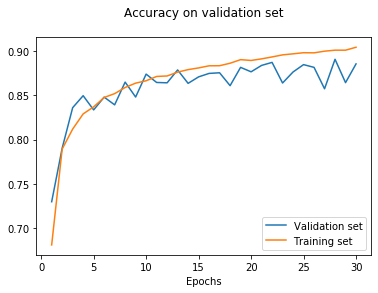

In [38]:
y1 = lr_momentum_history[max_ind].history['val_accuracy']
y1_label = 'Validation set'
y2 = lr_momentum_history[max_ind].history['accuracy']
y2_label = 'Training set'
plot_results (y1, y1_label, y2, y2_label, "Accuracy on validation set\n")

Even though introducing learning rate and momentum did not contribute to the increasing of accuracy, as chart shows it made validation and trining sets accuracies sit tighter to each other. It means that model now is capable to generalize better.


In [39]:
lr = param_dict[max_ind]['lr']
momentum = param_dict[max_ind]['momentum']

Last missed piece is the quantity of epochs. As per chart above, the least fluctuation and the highest accuracy is achieved around 10 epochs. Finally, as a result of theoretical findings and practical test, I get the following set of hyperparametrs and features to build and train model, and subsequently test it on unseen data:

In [40]:
print('The best hyperparametrs:\n')

print('Practicaly confirmed:\n')

print('Regularization:\t', l2)
print('Learning rate:\t', lr)
print('Momentum:\t', momentum)
print('Loss:\t\t', loss)
print('Epochs:\t\t', 10)

print('\nTheoretically defined:\n')

print('Hidden layers:\t', hidden_layers)
print('Hidden units:\t', hidden_units)
print('Activation:\t', activation)


print('\nMaximum accuracy on the \nvalidation set:\t', np.max(l2_max_accuracies))

The best hyperparametrs:

Practicaly confirmed:

Regularization:	 0.01
Learning rate:	 0.001
Momentum:	 0.005
Loss:		 categorical_crossentropy
Epochs:		 10

Theoretically defined:

Hidden layers:	 2
Hidden units:	 512
Activation:	 ['relu', 'softmax']

Maximum accuracy on the 
validation set:	 0.8962000012397766


#### 3. Testing

Fitting model onto unseen data:

In [41]:
epochs = 10
history_fin = []
model_fin = experiment(activation, hidden_units, hidden_layers, loss,
                       learning_rate = lr, momentum = momentum, l2=l2)
history_fin = model_fin.fit(x_train_part, y_train_hot_part, epochs = epochs, 
              batch_size = batch_size,
              validation_data = (x_train_val, y_train_hot_val))
y_pred = model_fin.predict(x_test)


Epoch 1/10
98/98 [==============================] - 5s 44ms/step - loss: 3.9459 - accuracy: 0.6820 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 1.6237 - val_accuracy: 0.6275 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 2/10
98/98 [==============================] - 4s 39ms/step - loss: 0.9260 - accuracy: 0.7853 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.7119 - val_accuracy: 0.8120 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 3/10
98/98 [==============================] - 4s 39ms/step - loss: 0.6778 - accuracy: 0.8118 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.6213 - val_accuracy: 0.8208 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 4/10
98/98 [==============================] - 4s 42ms/step - loss: 0.5871 - accuracy: 0.8286 - Multilabel_confusion_matrix: 12500.0000 - val_loss: 0.6124 - val_accuracy: 0.8156 - val_Multilabel_confusion_matrix: 2500.0000
Epoch 5/10
98/98 [==============================] - 4s 42ms/step - loss: 0.5465 - accura

In [42]:
#decoding of the results
y_pred_labeled = []
y_pred_prob = []
for pred in y_pred:
    y_pred_labeled.append(np.argmax(pred))
    y_pred_prob.append(np.max(pred))

Interpreting of the results is presented below.

# Results

### Evaluation

Below is the process of analyzing performance of the trained model on unseen (test) data. The main goal here is to make sure that model is able to generalize, find weak sides causing undeperformance (if they are) and suggest solutions.
The structure of this section is:
1. Accuracy:
    - overall 
    - per class
2. Confusion Matrix, Precision, Recall
3. Visualization

**1. Accuracy**

Overall accuracy:

In [43]:
accuracy_overall = np.round(history_fin.history["accuracy"][-1], 2)
print("Overall accuracy at the last epoch is ", accuracy_overall)
print("It satisfies the chosen baseline of 85%")

Overall accuracy at the last epoch is  0.87
It satisfies the chosen baseline of 85%


Accuracy per class with custom function:

In [44]:
def acc_per_class(y_test, y_pred, labels):
    
    values, counts = np.unique(y_test, return_counts = True)
    test_dict = {k:v for k,v in zip(values,counts)}
    
    counters = np.zeros((len(labels)))
    correct_pred_dict = {k:v for k,v in zip(labels,counters)}
    
    for i in range(len(y_test)):
        for j in labels:
            if y_test[i] == j and y_pred_labeled[i] == j:
                correct_pred_dict[j] = correct_pred_dict[j] + 1
    
    accuracy_per_class = {}
    for i in correct_pred_dict:
        accuracy_per_class[i] =  np.round((correct_pred_dict[i]/test_dict[i]),2)
        
    
    return accuracy_per_class, correct_pred_dict

In [45]:
labels = [0, 1,2,3,4,5,6,7,8,9]
accuracy_per_class, correct_pred_dict = acc_per_class(y_test, y_pred_labeled, labels)
print("Accuracy per class:\n")

for i in accuracy_per_class:
    print("Class: ", i, " accuracy: ", accuracy_per_class[i], "clothes :", clothes[i])


Accuracy per class:

Class:  0  accuracy:  0.82 clothes : T-shirt/top
Class:  1  accuracy:  0.94 clothes : Trousers
Class:  2  accuracy:  0.68 clothes : Pullover
Class:  3  accuracy:  0.91 clothes : Dress
Class:  4  accuracy:  0.72 clothes : Coat
Class:  5  accuracy:  0.97 clothes : Sandal
Class:  6  accuracy:  0.68 clothes : Shirt
Class:  7  accuracy:  0.94 clothes : Sneaker
Class:  8  accuracy:  0.97 clothes : Bag
Class:  9  accuracy:  0.92 clothes : Ankle boot


Products T-shirt, Pullover, Coat and Shirt are predicted with poor accuracy. Confusion matrix will help to identify the probable cause of poor performance on these categories. 

**2. Confusion Matrix, Precision/Recall**

In [46]:
conf_matrix = tf.math.confusion_matrix(y_test, y_pred_labeled, num_classes=10, weights=None, dtype=tf.dtypes.int32, name=None)

Confusion matrix: 



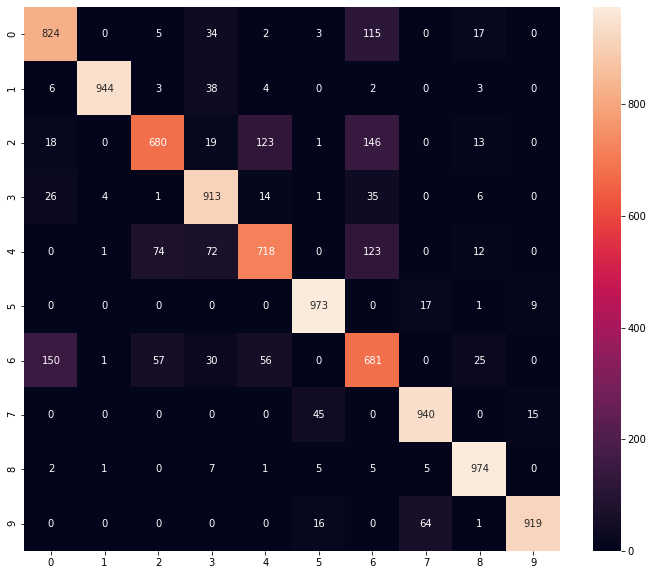

In [47]:
fig, ax = plt.subplots(figsize=(12,10))
print("Confusion matrix: \n")
sns.heatmap(conf_matrix, annot = conf_matrix, fmt = 'd')

From the heatmap it comes evident, that T-shirt (class 0) and Shirt (class 6) are often predicted as each other - 115 and 150 wrong predictions respectively. Coat (class 6) and Pullover (class 2) bring quite a lot mispredicted results too. Pullover is frequently idetified by model as Shirt (146 times) and Coat (123 times). While Shirt was 150 times identified as T-shirt and only 57 as Pullover .Speaking of Coat (class 4), it was 123 times predictes as Shirt, and somewhat more than 70 times as Pullover and Dress each. I find interesting that mistakes mostly do not mirror each other, meaning that if object A is frequently mispredicted as object B, it does not necessarily mean that object B is often mispredicted as object A. 

In [48]:
def precision_recall (y_pred, y_test, cls, correct_pred_dict):
    
    precision = 0
    recall = 0
    correctly_predicted_all = correct_pred_dict [cls]
    predicted_overall = 0
    overall_qty = 0
    
    for i in range(len(y_pred)):
        if y_pred[i] == cls:
            predicted_overall = predicted_overall + 1
        if y_test[i] == cls:
            overall_qty = overall_qty + 1
    
    precision = correctly_predicted_all/predicted_overall
    recall = correctly_predicted_all/overall_qty
    
    return np.round(precision, 3), np.round(recall, 3)

In [49]:
prec_recall_arr = []

for i in clothes:
    tmp = (clothes[i], 
           precision_recall(y_pred_labeled, y_test, i, correct_pred_dict)[0], 
           precision_recall(y_pred_labeled, y_test, i, correct_pred_dict)[1])
    prec_recall_arr.append(tmp)

df = pd.DataFrame(prec_recall_arr, columns = ["Clothes", "Precision", "Recall"])
df

,Clothes,Precision,Recall
0,T-shirt/top,0.803,0.824
1,Trousers,0.993,0.944
2,Pullover,0.829,0.680
3,Dress,0.820,0.913
4,Coat,0.782,0.718
5,Sandal,0.932,0.973
6,Shirt,0.615,0.681
7,Sneaker,0.916,0.940
8,Bag,0.926,0.974
9,Ankle boot,0.975,0.919


The table above confirms conclusions made based on accuracy and confusion matrix values. For example, it also shows that Shirt product is a bottleneck of the model: when model predicts the product as Shirt, this prediciton is correct only in 61.5% of cases. In the same time recall measure shows that product Shirt is recognized only in 68.1%. Quite low precision is also observed for Coat - prediction are correct only in 78.2%, and in the same time coat is predicted as coat in only 71.8% of times. One of the lowest recall value is observed for Pullover product (68.0%), which is align with confusion matrix that shows it is the most mispredicted item together with Shirt.

**3. Visualization**

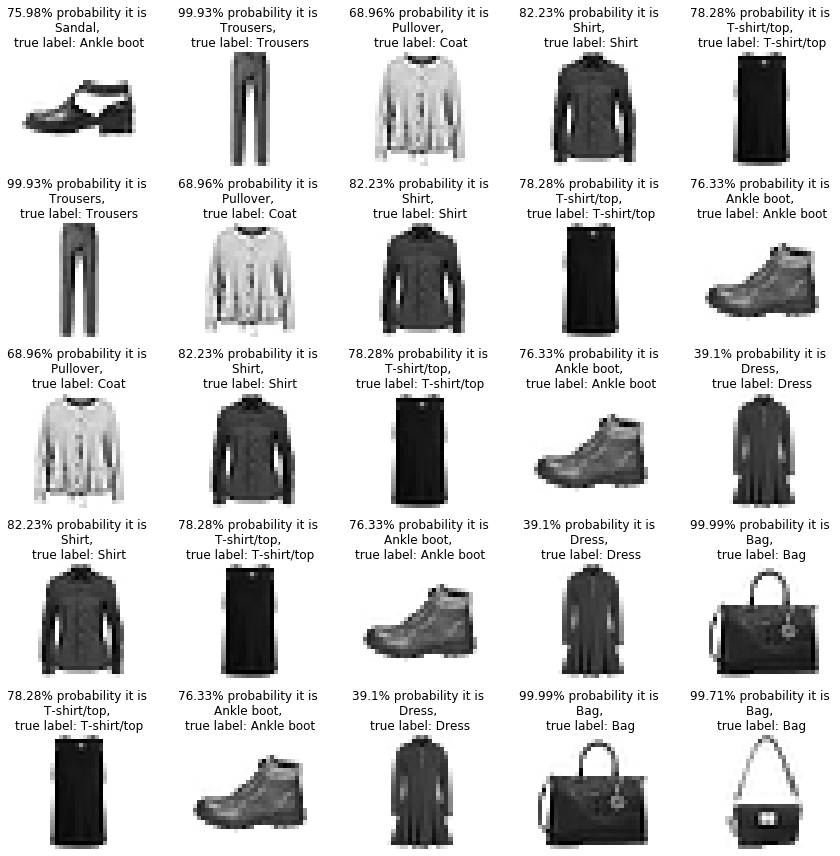

In [50]:
on_top = 23
fig, axs = plt.subplots(5,5,figsize=(12, 12))  
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(x_test_orig[i+j+on_top], cmap = plt.cm.binary)
        axs[i,j].set_title(str(np.round((y_pred_prob[i+j+on_top])*100,2)) + 
                           "% probability it is \n" + str(clothes[y_pred_labeled[i+j+on_top]]) + 
                           ", \ntrue label: " + str(clothes[y_test[i+j+on_top]]))
        axs[i,j].axis('off')
            
fig.tight_layout()
plt.show()

# Conclusion

As per findings of this coursework, the best set of the hyperparametrs and features for the image recognition problem solved by DNN with dense layers is:

- Practicaly confirmed:

    - Regularization:	 0.01
    - Learning rate:	 0.001
    - Momentum:	 0.01
    - Loss:		 categorical_crossentropy

- Theoretically defined:

    - Hidden layers:	 2
    - Hidden units:	 512
    - Activation:	 ['relu', 'softmax']



- Maximum accuracy on the validation set:	 0.89
- Accuracy on the test set: 0.87

The model exceed the baseline of 85% accuracy and is trained to predict with **87%** confidence. However, from the evaluation section it becomes evident that accuracies extremely vary from class to class. For Trousers, Ankle Boot, Bag and Sandal, for example, accuracy of prediction is 90-95% +, while Shirt and Pullover barely reaches 68% of confidence. None hand accuarcy of Coat prediciton is 72 %, on another - coat controbutes to Pullover misprediction.

The last plot shows that for some data samples probability of prediction was as low as 39.1% for Dress predicted correctly and 68.96% for Coat predicted as Pullover. This level is unacceptable speaking of any prediction confidence and hihglights the need if dataset improvement. If I were to manage the dataset, I would definitely look into improving quality of images of Pullovers, Shirts, T-shirts and Coats, as well as increasing training samples of each. Eeven though the dataset will become less balanced after, in my opinion this will contribute to the overall preformance improvement.